### Problem statement:
 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [61]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [4]:
os.listdir()

['.config',
 'gdrive',
 'Skin cancer ISIC The International Skin Imaging Collaboration',
 'sample_data']

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing <BR>
Let's load these images off disk using the helpful<BR> image_dataset_from_directory utility.

### Create a dataset
Defining some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

we will Use 80% of the images for training, and 20% for validation.

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_height,img_width),
                                                                batch_size=32,seed=132,validation_split=0.2,subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_height,img_width),
                                                                batch_size=32,seed=132,validation_split=0.2,subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
**create a code to visualize one instance of all the nine classes present in the dataset**

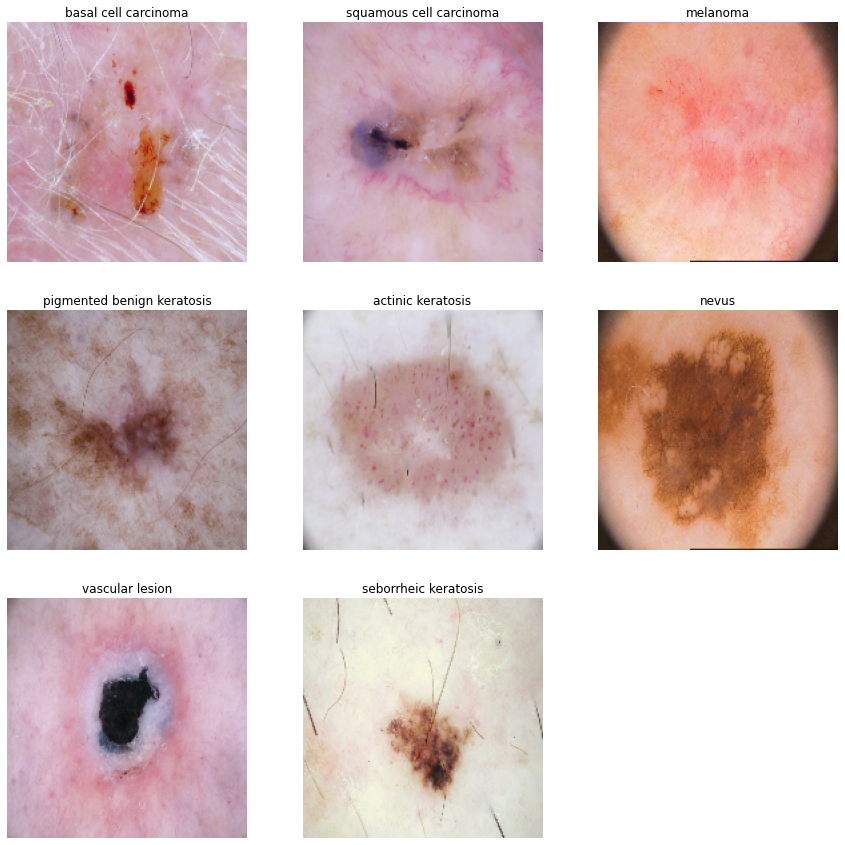

In [11]:
plt.figure(figsize=[15,15])
index=0
classset=[]
for images,labels in train_ds.take(1):
  for i in range(batch_size):
    if class_names[labels[i]] not in classset:
      index +=1
      classset.append(class_names[labels[i]])
      plt.subplot(3,3,index)
      plt.imshow(images[i].numpy().astype('int'))
      plt.title(class_names[labels[i]])
      plt.axis('off')

**We will notice we can not guarentee the presence of all 9 classes in one batch , hence i am coding<BR> another approach for displaying one instance of  9 classes below**

In [12]:
pref=str(data_dir_train)+'/'
path_per_class=[]
for cls in class_names:
    path_per_class.append(pref+cls+'/')
path_per_class
path_per_class_image=[]
for path in path_per_class:
  path_per_class_image.append(path+os.listdir(path)[0])

path_per_class_image

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027896.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0027858.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0026789.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000462.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0027896.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025548.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010866.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0029462.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

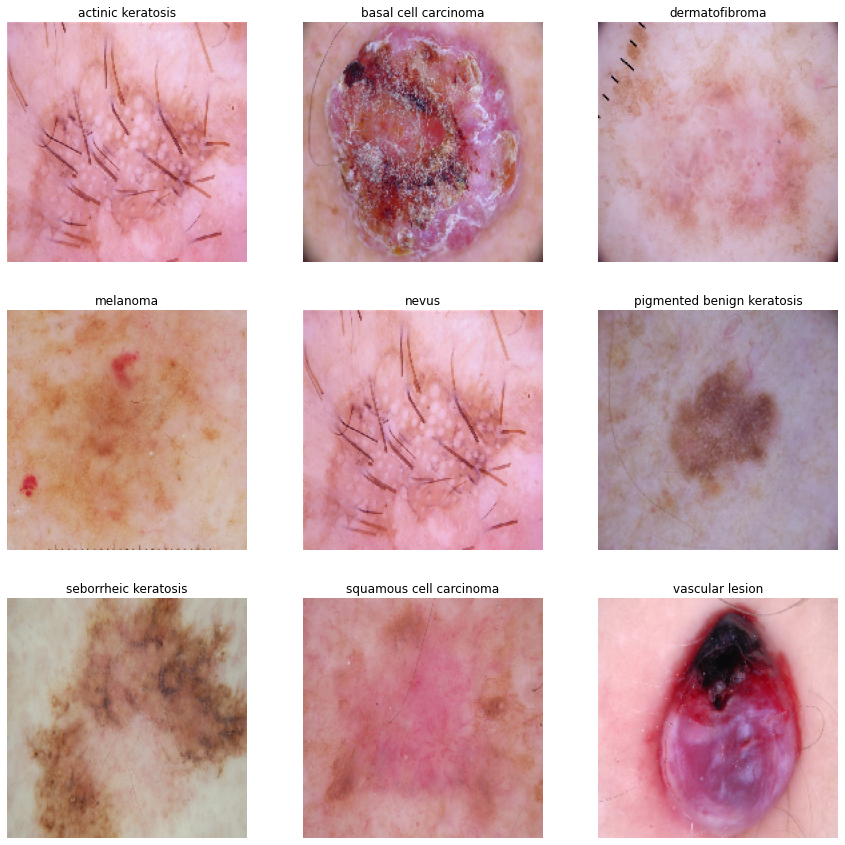

In [13]:
i=0
plt.figure(figsize=[15,15])
for paths in path_per_class_image:
  image_data=tf.keras.preprocessing.image.load_img(paths,target_size=(img_width,img_height))
  plt.subplot(3,3,i+1)
  plt.imshow(image_data)
  plt.title(class_names[i])
  plt.axis('off')
  i +=1

**The image_batch** is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The **label_batch** is a tensor of the shape (32,), these are corresponding labels to the 32 images.

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
We will Create a CNN model, which can accurately detect 9 classes present in the dataset.We will  Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [15]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255,input_shape=(img_width,img_height,3)))
model.add(tf.keras.layers.Conv2D(8,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(9,activation='softmax'))

### Compile the model

In [16]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 64)        18496     
                                                        

### Train the model

In [17]:
history=model.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
56/56 [==============================] - 201s 3s/step - loss: 2.0155 - accuracy: 0.2188 - val_loss: 1.9634 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 186s 3s/step - loss: 1.7786 - accuracy: 0.3331 - val_loss: 1.5632 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 184s 3s/step - loss: 1.6409 - accuracy: 0.3862 - val_loss: 1.5364 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 184s 3s/step - loss: 1.5749 - accuracy: 0.4342 - val_loss: 1.4584 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 186s 3s/step - loss: 1.5094 - accuracy: 0.4481 - val_loss: 1.4376 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 183s 3s/step - loss: 1.4904 - accuracy: 0.4604 - val_loss: 1.4144 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 184s 3s/step - loss: 1.4418 - accuracy: 0.4754 - val_loss: 1.3647 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing training results

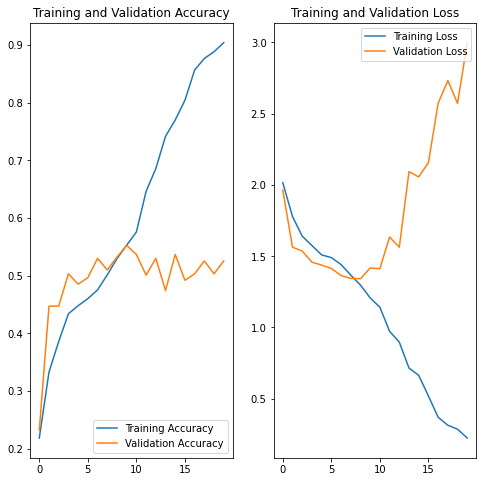

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation -:**
We can see the training accuracy is linearly increasing while validation accuracy is oscillating around 50% 
Also we can see there is an increment in validation loss as we procced with more numbers of epochs.<BR>
**Why such behaviour ?**
All of the above observation leads to the fact that the model is overfitting the training data set . To fight overfitting we might test the data for class imbalance  , and test the model architecture with dropout layers.

One way to fight overfitting is to **create samles from existing images** from the dataset to balance out the class or to have good number of samples in each class.
<BR>
**To visualize how augmentated samples look like** we can pass our data set (images)
through a sequential model with certain image augmentation functions stacked as layers.

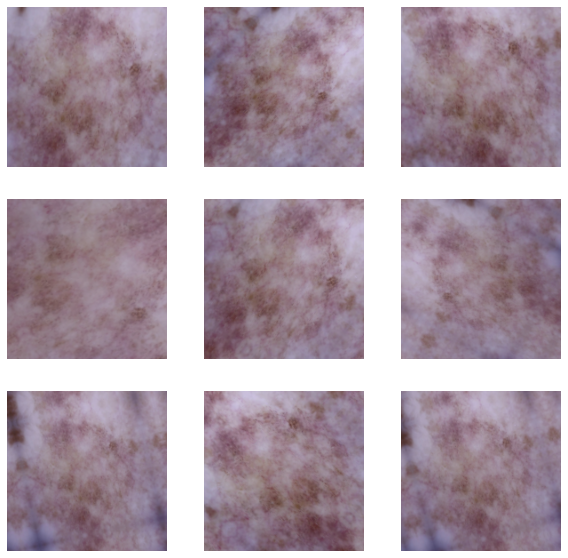

In [23]:
augmentor=tf.keras.Sequential()
augmentor.add(tf.keras.layers.RandomFlip(mode='horizontal',input_shape=(img_width,img_height,3)))
augmentor.add(tf.keras.layers.RandomZoom(0.3))
augmentor.add(tf.keras.layers.RandomContrast(0.35))
augmentor.add(tf.keras.layers.RandomRotation(0.2))

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = augmentor(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

We can see how data augmentor technique works using a sequntial model , but later when we will try to create samples we will use a liabrary called **Augmentor** to handle file operations for sample images  for us internally , to avoid overfitting.

For now let's focus on introducing dropout layers in our model architechture before starting of fully connected layers and output layers . A good suggestion in **stackoverflow** [link](https://stackoverflow.com/questions/47701544/does-dropout-layer-go-before-or-after-dense-layer-in-tensorflow#:~:text=Informally%20speaking%2C%20common%20wisdom%20says%20to%20apply%20dropout,the%20prev_layer%20is%20in%20your%20second%20code%20snippet.) about introducing dropout layers in our model architechture.

### Create the model, compile and train the model

In [32]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255,input_shape=(img_width,img_height,3)))
model.add(tf.keras.layers.Conv2D(8,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.20))
model.add(tf.keras.layers.Dense(9,activation='softmax'))

In [33]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 8)       224       
                                                                 
 conv2d_25 (Conv2D)          (None, 176, 176, 16)      1168      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 86, 86, 32)        4640      
                                                                 
 conv2d_27 (Conv2D)          (None, 84, 84, 64)        18496     
                                                      

In [34]:
history=model.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
56/56 [==============================] - 189s 3s/step - loss: 2.0125 - accuracy: 0.2472 - val_loss: 1.8029 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 195s 3s/step - loss: 1.7666 - accuracy: 0.3705 - val_loss: 1.6572 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 190s 3s/step - loss: 1.6397 - accuracy: 0.4029 - val_loss: 1.4249 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 191s 3s/step - loss: 1.5650 - accuracy: 0.4358 - val_loss: 1.3616 - val_accuracy: 0.5459
Epoch 5/20
56/56 [==============================] - 189s 3s/step - loss: 1.4813 - accuracy: 0.4860 - val_loss: 1.4526 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 189s 3s/step - loss: 1.4139 - accuracy: 0.4967 - val_loss: 1.3762 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 190s 3s/step - loss: 1.3881 - accuracy: 0.5006 - val_loss: 1.3813 - val_accuracy: 0.5347
Epoch 8/20
56

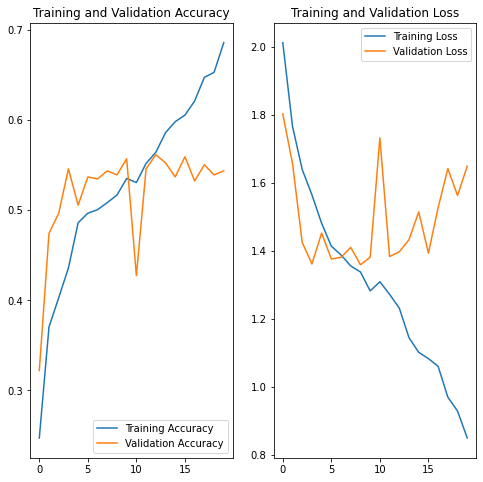

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Introducing **dropout layers** in our model architechture is leading to decrement the **difference between the train and validation accuracy** significantly , but still we are not able to achive a good accuracy score , so we can say the model is **underperforming**.


 Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
count_list={}
for dirs in data_dir_train.iterdir():
  count_list[dirs.stem]=len(list(dirs.glob('*.jpg')))

In [42]:
class_counts=pd.DataFrame(list(count_list.items()),columns=['class','count'])

In [43]:
class_counts

,class,count
0,actinic keratosis,114
1,seborrheic keratosis,77
2,vascular lesion,139
3,dermatofibroma,95
4,melanoma,438
5,nevus,357
6,pigmented benign keratosis,462
7,squamous cell carcinoma,181
8,basal cell carcinoma,376


In [44]:
import seaborn as sns

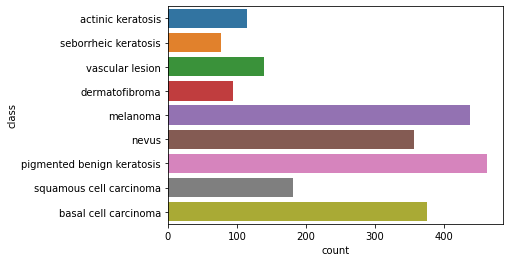

In [53]:
sns.barplot(data=class_counts,x='count',y='class',orient='horizontal')
plt.show()

from above distribution plot we can see the minimum number of samples are present in **seborrhetic keratosis** , while **pigmented benign keratosis** class is dominating the distribution.

We can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [55]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [58]:
path_to_training_dataset= str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAF5A21E190>: 100%|██████████| 500/500 [00:20<00:00, 24.78 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAF5CFA1210>: 100%|██████████| 500/500 [00:19<00:00, 25.04 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAF5A3C0B50>: 100%|██████████| 500/500 [00:20<00:00, 23.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FAF5A2C8D50>: 100%|██████████| 500/500 [01:45<00:00,  4.76 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FAF5A2C8910>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAF5A26CD90>: 100%|██████████| 500/500 [00:20<00:00, 24.46 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAF5B1BF590>: 100%|██████████| 500/500 [00:49<00:00, 10.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAF5A7E9A10>: 100%|██████████| 500/500 [00:59<00:00,  8.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAF5A592410>: 100%|██████████| 500/500 [00:19<00:00, 25.21 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images


In [59]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.


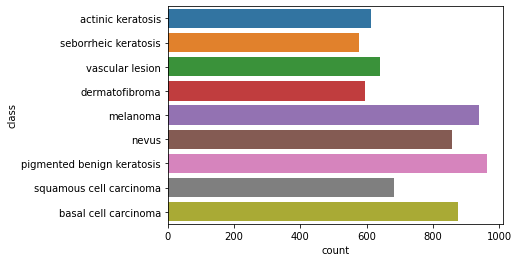

In [66]:
count_list={}
for dirs in data_dir_train.iterdir():
  count_list[dirs.stem]=len(list(dirs.glob('*.jpg')))+len(list(dirs.glob('output/*.jpg')))
class_counts=pd.DataFrame(list(count_list.items()),columns=['class','count'])
sns.barplot(data=class_counts,x='count',y='class',orient='horizontal')
plt.show()

### Creating a training dataset(After data augmentation)

In [71]:
train_aug_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                       image_size=(img_width,img_height),batch_size=32,seed=123,validation_split=0.2,subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Creating validation dataset (After augmentation)

In [72]:
val_aug_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                       image_size=(img_width,img_height),batch_size=32,seed=123,validation_split=0.2,subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model building(After augmentation)

In [73]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255,input_shape=(img_width,img_height,3)))
model.add(tf.keras.layers.Conv2D(8,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.20))
model.add(tf.keras.layers.Dense(9,activation='softmax'))

In [74]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 178, 178, 8)       224       
                                                                 
 conv2d_31 (Conv2D)          (None, 176, 176, 16)      1168      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 86, 86, 32)        4640      
                                                                 
 conv2d_33 (Conv2D)          (None, 84, 84, 64)        18496     
                                                      

### Training model(After augmentation)

In [75]:
history=model.fit(train_aug_ds,validation_data=val_aug_ds,epochs=30)

Epoch 1/30
169/169 [==============================] - 592s 3s/step - loss: 2.2110 - accuracy: 0.1487 - val_loss: 2.0997 - val_accuracy: 0.1834
Epoch 2/30
169/169 [==============================] - 592s 4s/step - loss: 2.0494 - accuracy: 0.2250 - val_loss: 2.0536 - val_accuracy: 0.2465
Epoch 3/30
169/169 [==============================] - 586s 3s/step - loss: 1.8676 - accuracy: 0.3014 - val_loss: 1.8250 - val_accuracy: 0.3111
Epoch 4/30
169/169 [==============================] - 593s 4s/step - loss: 1.6082 - accuracy: 0.4136 - val_loss: 1.4219 - val_accuracy: 0.4699
Epoch 5/30
169/169 [==============================] - 591s 3s/step - loss: 1.2831 - accuracy: 0.5315 - val_loss: 1.2352 - val_accuracy: 0.5523
Epoch 6/30
169/169 [==============================] - 590s 3s/step - loss: 0.9340 - accuracy: 0.6641 - val_loss: 0.9645 - val_accuracy: 0.6644
Epoch 7/30
169/169 [==============================] - 590s 3s/step - loss: 0.6791 - accuracy: 0.7585 - val_loss: 0.9969 - val_accuracy: 0.6733

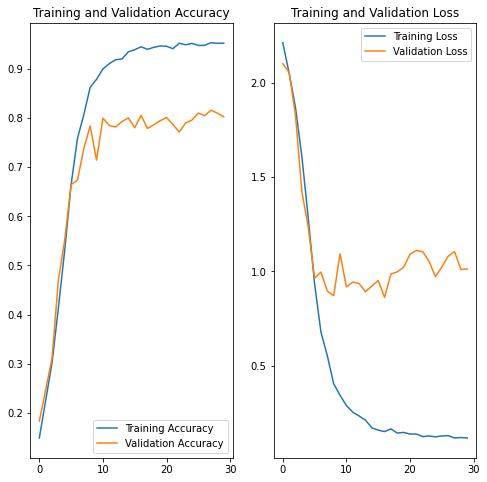

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation :
We can see the augmentation of images is significantly reducing the overfit and improving model accuracy significantly, which indeed a good step . We can improve our model further using better architechture and creating more samples by augmentation.

### Let's plot the model architechture

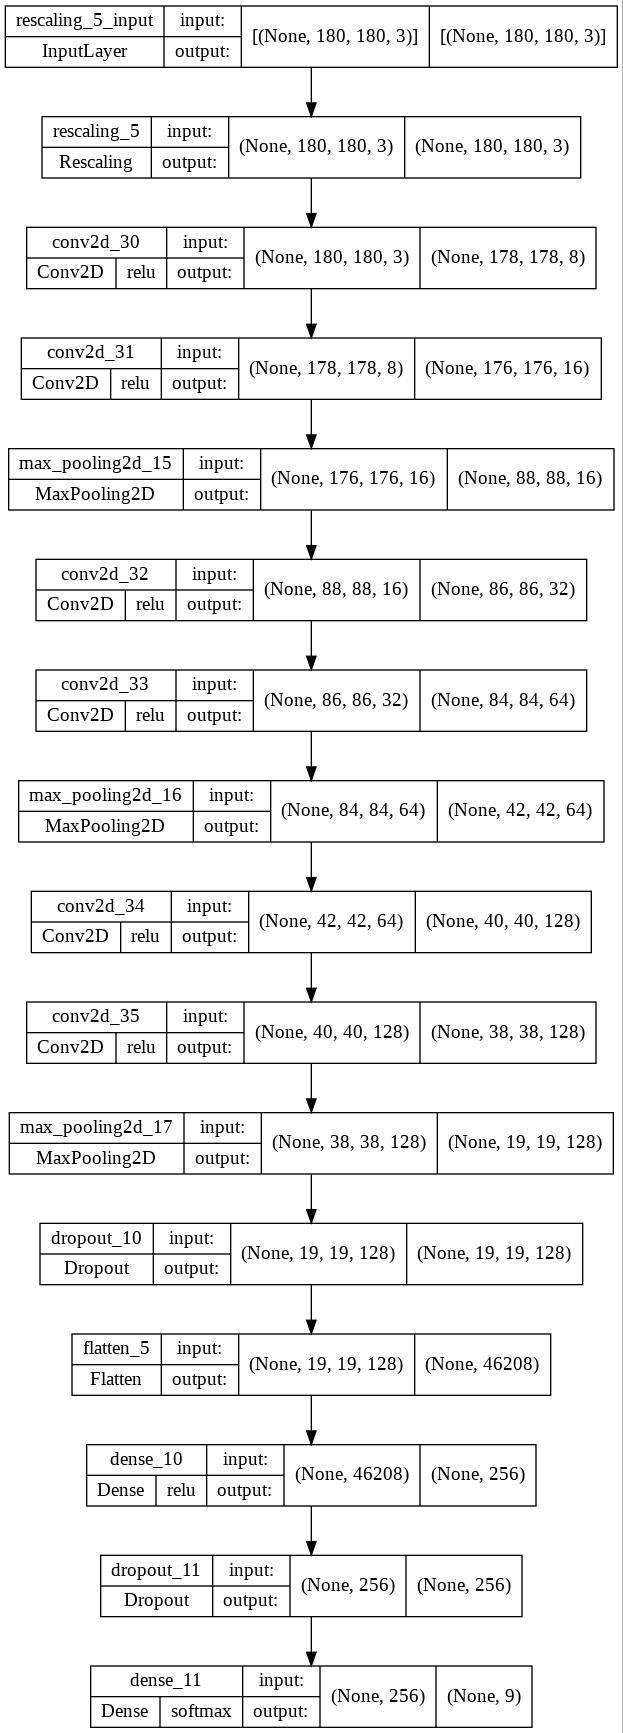

In [80]:
from tensorflow.keras.utils import plot_model
plot_model(model,'CNNafteraug.jpg',show_layer_names=True,show_shapes=True,show_layer_activations=True)